In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from itertools import cycle, islice
from math import sqrt

%matplotlib inline

In [2]:
# Create sql connection
cnx = sqlite3.connect('wfdata.sqlite')

In [3]:
# Tables
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

spatial_ref_sys
spatialite_history
sqlite_sequence
geometry_columns
spatial_ref_sys_aux
views_geometry_columns
virts_geometry_columns
geometry_columns_statistics
views_geometry_columns_statistics
virts_geometry_columns_statistics
geometry_columns_field_infos
views_geometry_columns_field_infos
virts_geometry_columns_field_infos
geometry_columns_time
geometry_columns_auth
views_geometry_columns_auth
virts_geometry_columns_auth
sql_statements_log
SpatialIndex
ElementaryGeometries
KNN
Fires
idx_Fires_Shape
idx_Fires_Shape_node
idx_Fires_Shape_rowid
idx_Fires_Shape_parent
NWCG_UnitIDActive_20170109


In [4]:
# Read selected features from the table Fire
df = pd.read_sql_query("SELECT \
                            OBJECTID, FIRE_NAME,FIRE_YEAR, DISCOVERY_DATE,\
                            DISCOVERY_DOY, DISCOVERY_TIME, STAT_CAUSE_CODE,\
                            STAT_CAUSE_DESCR, CONT_DATE, CONT_DOY, CONT_TIME,\
                            FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE,LONGITUDE,\
                            OWNER_CODE,OWNER_DESCR, STATE, COUNTY, FIPS_NAME \
                            FROM Fires", cnx)

In [5]:
df.head()

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME
0,1,FOUNTAIN,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,Plumas
1,2,PIGEON,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,Placer
2,3,SLACK,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,El Dorado
3,4,DEER,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,Alpine
4,5,STEVENOT,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,Alpine


In [6]:
df.shape

(1880465, 20)

# Initial Data Exploration

## Wildfire in US

In [7]:
# yearly number of fires
numFire_year = df['FIRE_YEAR'].value_counts().sort_index()

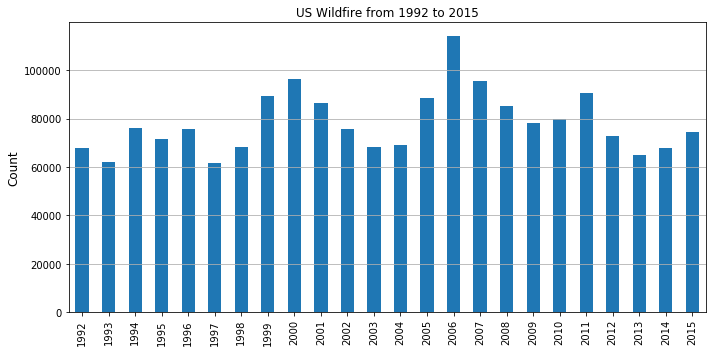

In [79]:
# plot yearly number of fires
fig, axs = plt.subplots(figsize=(10, 5))
numFire_year.plot(kind='bar', ax=axs)
axs.set_title('US Wildfire from 1992 to 2015')
axs.set_ylabel('Count', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

In [69]:
numFire_year.describe()

count        24.000000
mean      78352.708333
std       12759.039409
min       61450.000000
25%       68342.750000
50%       75615.000000
75%       87091.250000
max      114004.000000
Name: FIRE_YEAR, dtype: float64

## Wildfire in California

In [10]:
# data for wildfire in California
df_CA = df[df['STATE']=='CA']

In [11]:
df_CA.head()

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME
0,1,FOUNTAIN,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,Plumas
1,2,PIGEON,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,Placer
2,3,SLACK,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,El Dorado
3,4,DEER,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,Alpine
4,5,STEVENOT,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,Alpine


In [12]:
numFire_year_CA = df_CA['FIRE_YEAR'].value_counts().sort_index()

In [14]:
numFire_year_CA.describe()

count       24.000000
mean      7897.916667
std       1162.025178
min       5776.000000
25%       7094.000000
50%       7828.500000
75%       8585.000000
max      10833.000000
Name: FIRE_YEAR, dtype: float64

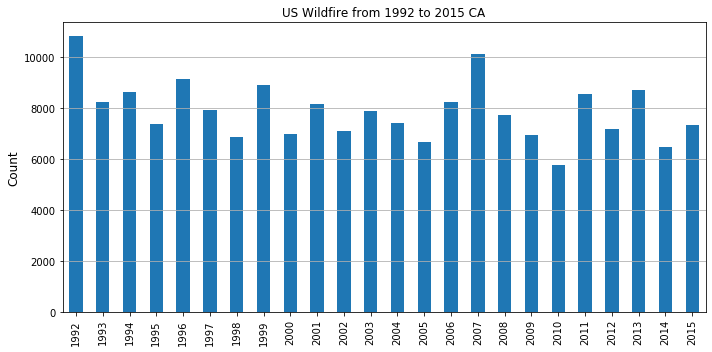

In [78]:
fig, axs = plt.subplots(figsize=(10, 5))
numFire_year_CA.plot(kind='bar')
axs.set_title('US Wildfire from 1992 to 2015 CA', fontsize=12)
axs.set_ylabel('Count', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

## Most and least fire prone counties in California

In [16]:
counties = df_CA['FIPS_NAME'].value_counts().sort_values(ascending=False)
print('number of counties in CA =', len(counties))

number of counties in CA = 59


In [17]:
counties.describe()

count      59.000000
mean      952.898305
std      1091.072151
min         1.000000
25%       246.500000
50%       591.000000
75%      1265.000000
max      6925.000000
Name: FIPS_NAME, dtype: float64

In [18]:
# ten most fire-prone counties
counties[:10]

Riverside         6925
Los Angeles       2703
El Dorado         2676
San Bernardino    2642
San Diego         2443
Fresno            2183
Siskiyou          2156
Shasta            2118
Butte             1768
Kern              1737
Name: FIPS_NAME, dtype: int64

In [20]:
# ten least fire-prone counties
counties[-10:]

San Benito       157
Solano           149
Ventura          132
Kings            119
Colusa           111
Glenn             94
Marin             69
Sutter            68
San Francisco     15
Douglas            1
Name: FIPS_NAME, dtype: int64

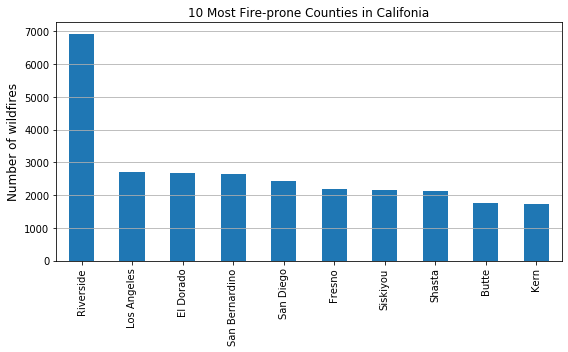

In [96]:
# plot ten most fire-prone counties
fig, axs = plt.subplots(figsize=(8, 5))
counties[:10].plot(kind='bar')
axs.set_title('10 Most Fire-prone Counties in Califonia', fontsize=12)
plt.ylabel('Number of wildfires', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

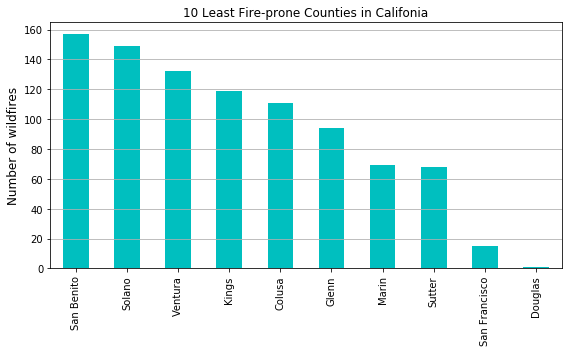

In [103]:
# plot ten least fire-prone counties
fig, axs = plt.subplots(figsize=(8, 5))
counties[-10:].plot(kind='bar', color='c')
axs.set_title('10 Least Fire-prone Counties in Califonia', fontsize=12)
axs.set_ylabel('Number of wildfires', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

## Fire size

In [23]:
fire_size = df_CA['FIRE_SIZE_CLASS'].value_counts().sort_index()

In [117]:
fire_size_catagories = {'A': '0.25', 'B': '0.26, 9.9', 'C': '10.0, 99.9',
                        'D': '100, 299', 'E': '300, 999', 'F': '1000,4999', 'G': '5000'}

In [24]:
fire_size

A    98309
B    76942
C     9825
D     2137
E     1187
F      756
G      394
Name: FIRE_SIZE_CLASS, dtype: int64

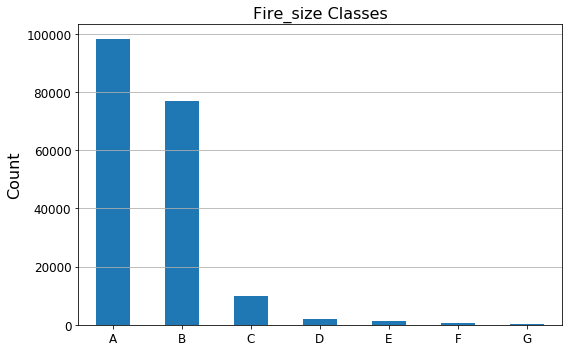

In [116]:
fig, axs = plt.subplots(figsize=(8, 5))
fire_size.plot(kind='bar')
axs.set_title('Fire_size Classes', fontsize=16)
axs.set_ylabel('Count',fontsize = 16)
axs.yaxis.grid(True)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.tight_layout()

## Stated cause of fire

In [118]:
stated_cause = df_CA['STAT_CAUSE_DESCR'].value_counts(
).sort_values(ascending=False)

In [119]:
stated_cause

Miscellaneous        51943
Equipment Use        39407
Lightning            27000
Arson                19635
Debris Burning       14318
Missing/Undefined    12605
Campfire              9516
Children              6930
Smoking               5936
Powerline             1198
Railroad               720
Fireworks              219
Structure              123
Name: STAT_CAUSE_DESCR, dtype: int64

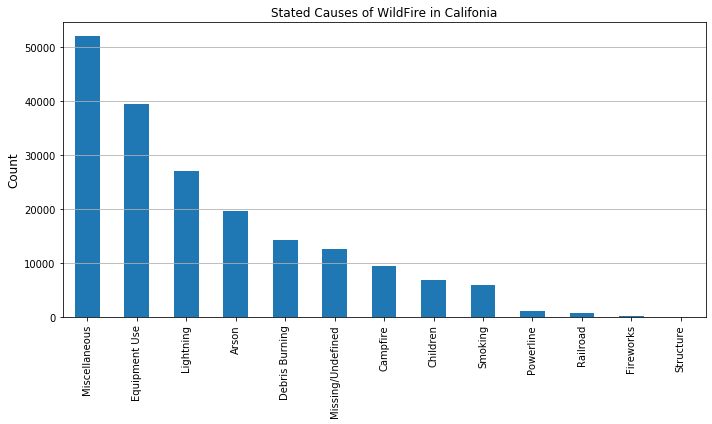

In [133]:
# plot stated cause of fire
fig, axs = plt.subplots(figsize=(10, 6))
stat_cause.plot(kind='bar')
axs.set_title('Stated Causes of WildFire in Califonia',fontsize=12)
axs.set_ylabel('Count',fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

# Data Preparation

In [30]:
len(df_CA)

189550

In [134]:
df_CA.count()

OBJECTID            189550
FIRE_NAME           174557
FIRE_YEAR           189550
DISCOVERY_DATE      189550
DISCOVERY_DOY       189550
DISCOVERY_TIME      110217
STAT_CAUSE_CODE     189550
STAT_CAUSE_DESCR    189550
CONT_DATE            91908
CONT_DOY             91908
CONT_TIME            91217
FIRE_SIZE           189550
FIRE_SIZE_CLASS     189550
LATITUDE            189550
LONGITUDE           189550
OWNER_CODE          189550
OWNER_DESCR         189550
STATE               189550
COUNTY               56221
FIPS_NAME            56221
dtype: int64

In [31]:
df_CA.isnull().any()

OBJECTID            False
FIRE_NAME            True
FIRE_YEAR           False
DISCOVERY_DATE      False
DISCOVERY_DOY       False
DISCOVERY_TIME       True
STAT_CAUSE_CODE     False
STAT_CAUSE_DESCR    False
CONT_DATE            True
CONT_DOY             True
CONT_TIME            True
FIRE_SIZE           False
FIRE_SIZE_CLASS     False
LATITUDE            False
LONGITUDE           False
OWNER_CODE          False
OWNER_DESCR         False
STATE               False
COUNTY               True
FIPS_NAME            True
dtype: bool

In [32]:
# percent of data dropped
def count_nan(data):
    return 100*(len(data) - len(data.dropna())) / len(data)

In [33]:
count_nan(df_CA['CONT_DOY'])

51.51252967554735

In [34]:
count_nan(df_CA['COUNTY'])

70.33975204431549

In [35]:
len(df_CA['DISCOVERY_TIME'].dropna())

110217

In [36]:
df_CA_0 = df_CA[['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
                 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'CONT_DATE', 'CONT_DOY',
                 'CONT_TIME', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE']]

In [37]:
len(df_CA_0)

189550

In [38]:
# percent of the data dropped because of NaN
count_nan(df_CA_0)

51.894486942759166

In [39]:
df_CA_1 = df_CA_0.dropna()
len(df_CA_1)

91184

In [40]:
df_CA_1.isnull().any()

OBJECTID           False
FIRE_YEAR          False
DISCOVERY_DATE     False
DISCOVERY_DOY      False
DISCOVERY_TIME     False
STAT_CAUSE_CODE    False
CONT_DATE          False
CONT_DOY           False
CONT_TIME          False
FIRE_SIZE          False
LATITUDE           False
LONGITUDE          False
OWNER_CODE         False
dtype: bool

### Predicting stated cause of fire 

In [41]:
df_CA_1.columns

Index(['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE'],
      dtype='object')

In [42]:
features = ['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
            'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']

In [43]:
df['STAT_CAUSE_DESCR'].unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

In [44]:
df[df['STAT_CAUSE_CODE'] == 3.0].head()

,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME
181,182,TASSAJARA 1,2005,2453567.5,197,0315,3.0,Smoking,2453568.5,198.0,1500,0.3,B,36.242500,-121.551111,5.0,USFS,CA,None,None
182,183,TASSAJARA 2,2005,2453567.5,197,0545,3.0,Smoking,2453567.5,197.0,1830,0.1,A,36.242500,-121.548056,5.0,USFS,CA,None,None
195,196,CEMETERY POINT,2005,2453569.5,199,1600,3.0,Smoking,2453569.5,199.0,1630,0.1,A,41.264167,-111.795833,5.0,USFS,UT,57,Weber
231,232,PECHACHO,2005,2453563.5,193,1445,3.0,Smoking,2453563.5,193.0,1530,0.1,A,35.464444,-118.756389,5.0,USFS,CA,None,None
280,281,BEAR,2005,2453553.5,183,1230,3.0,Smoking,2453553.5,183.0,1500,0.1,A,34.414444,-111.009722,5.0,USFS,AZ,5,Coconino


In [45]:
stat_cause_dict = {'Miscellaneous': 9.0,
                   'Lightning': 1.0,
                   'Debris Burning': 5.0,
                   'Missing/Undefined': 13.0,
                   'Equipment Use': 2.0,
                   'Campfire': 4.0,
                   'Children': 8.0,
                   'Smoking': 3.0,
                   'Railroad': 6.0,
                   'Powerline': 11.0,
                   'Fireworks': 10.0,
                   'Structure': 12.0,
                   'Arson': 7.0}

In [46]:
stat_cause_code = df['STAT_CAUSE_CODE'].unique().tolist()
print(stat_cause_code)

[9.0, 1.0, 5.0, 4.0, 2.0, 7.0, 8.0, 6.0, 3.0, 11.0, 12.0, 10.0, 13.0]


Partitioning the data
The data is shuffled and divided as follow:
85% of the data is used to perform bootstrap analysis of training variability. This data is partitioned into training and validation many times to produce many validation-set predictions for each example
70% Training: Used to train the model
15% Validation: Used to evaluate the model
15% of the data is held-out for final testing.

In [47]:
X = df_CA_1[features].to_numpy()

In [48]:
#y = np.int64((df_CA_1['STAT_CAUSE_CODE']).to_numpy())
# for one vs the rest binary classification
firecode = 9
y = ((df_CA_1['STAT_CAUSE_CODE'] == firecode) * 1).to_numpy()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [50]:
d_classifier = DecisionTreeClassifier(max_leaf_nodes=20)
d_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [51]:
# Validation
preds_val = d_classifier.predict(X_val)
print(preds_val[:20])
print(y_val[:20])
print('accuracy =', accuracy_score(y_true=y_val, y_pred=preds_val))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1]
accuracy = 0.7773797338792221


In [52]:
# Testing
preds = d_classifier.predict(X_test)
print(preds[:20])
print(y_test[:20])
print('accuracy =', accuracy_score(y_true=y_test, y_pred=preds))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
accuracy = 0.7686796315250768
